In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas 

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("./data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

Open    High     Low    Last  Change  Settle  Volume  \
Date                                                                 
1976-08-02  3398.0  3401.0  3398.0  3401.0     NaN  3401.0     2.0   
1976-08-03  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-04  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-05  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   
1976-08-06  3401.0  3401.0  3401.0  3401.0     NaN  3401.0     0.0   

            Previous Day Open Interest  
Date                                    
1976-08-02                         1.0  
1976-08-03                         1.0  
1976-08-04                         1.0  
1976-08-05                         1.0  
1976-08-06                         1.0

In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

Open    High     Low    Last  Change  Settle   Volume  \
Date                                                                  
1990-01-02  6954.0  6954.0  6835.0  6847.0     NaN  6847.0  48336.0   
1990-01-03  6877.0  6910.0  6865.0  6887.0     NaN  6887.0  38206.0   
1990-01-04  6937.0  7030.0  6924.0  7008.0     NaN  7008.0  49649.0   
1990-01-05  6952.0  6985.0  6942.0  6950.0     NaN  6950.0  29944.0   
1990-01-08  6936.0  6972.0  6936.0  6959.0     NaN  6959.0  19763.0   

            Previous Day Open Interest  
Date                                    
1990-01-02                     51473.0  
1990-01-03                     53860.0  
1990-01-04                     55699.0  
1990-01-05                     53111.0  
1990-01-08                     52072.0

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

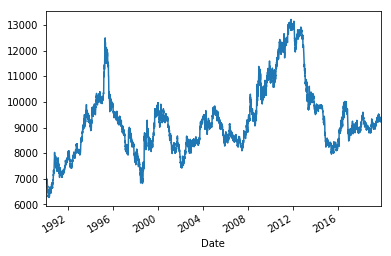

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot()

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df_yen=pd.DataFrame()
df_yen['Settle']=yen_futures.loc[:,'Settle']
df_yen.head()

Settle
Date              
1990-01-02  6847.0
1990-01-03  6887.0
1990-01-04  7008.0
1990-01-05  6950.0
1990-01-08  6959.0

In [7]:
df_yen=pd.concat([df_yen, yen_noise,yen_trend], axis=1, join='inner')
df_yen.columns=['settle','noise', 'trend']
df_yen.head()
# df_yen['noise']=yen_noise.iloc[:,0]
# df_yen['trend']=yen_trend.iloc[:,0]
# df_yen.head()

settle      noise        trend
Date                                      
1990-01-02  6847.0 -61.503967  6908.503967
1990-01-03  6887.0 -21.799756  6908.799756
1990-01-04  7008.0  98.942896  6909.057104
1990-01-05  6950.0  40.776052  6909.223948
1990-01-08  6959.0  49.689938  6909.310062

In [8]:
# Plot the Settle Price vs. the Trend
df_yen.hvplot(y=['settle', 'trend'],  ylabel='returns',xlabel='Date').opts(title='Settle vs. Trend')


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [9]:
# Plot the Settle Noise
df_yen.hvplot(y='noise').opts(title='Noise')

:Curve   [Date]   (noise)

In [10]:
'''just for the hell of it, I tried decomposing the time series into the trend, seasonal and noise component
by doing wavelet tranform, by first decomposing the signal into trend and stuff, then decomposing the stuff 
into seasonal and noise. The season/noise break down was less successfull'''

import pywt
import statistics
import numpy as np
wave='coif3'
coeffs = pywt.wavedec(df_yen['settle'], wave, mode='symmetric', level=None)

In [11]:
def thresholding(coeff, df, level, val):
    MAD=[]
    m=np.median(coeff[level])
    for ele in range(coeff[level].size):
        MAD.append(abs(coeff[level][ele]-m))
    sigma=statistics.median(MAD)/val
    threshold=sigma*np.sqrt(2*np.log(yen_futures['Settle'].size))
    return threshold

full_noise=[]
full_trend=[]
for level in range(len(coeffs)):
    noise=[]
    trend=[]
#     val=.6745
    val=.6745
    threshold=thresholding(coeffs, df_yen, level, val)
    print(threshold)
    
    for ele in range(coeffs[level].size):
        z=coeffs[level][ele]
        if abs(z)>=threshold:
            trend.append(z)
            noise.append(0)
        else:
            noise.append(z)
            trend.append(0)
            
    noise_array=np.array(noise)
    trend_array=np.array(trend)
    full_noise.append(noise_array)
    full_trend.append(trend_array)
    
print('done')

74260.076960208
7182.650196622074
6608.07324774632
2689.0221542687937
1713.7861248977943
850.9102824773194
427.1709236633419
224.8584642515548
126.42867096055673
done


In [12]:
trend_wave=pywt.waverec(full_trend, wave, mode='symmetric', axis=-1)
wavet=np.delete(trend_wave,-1)
df_yen['wave_trend']=wavet
df_yen.head()
df_yen.hvplot(y=['wave_trend','settle', 'trend']).opts(title='trend')


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [16]:
noise_wave=pywt.waverec(full_noise, wave, mode='symmetric', axis=-1)
waven=np.delete(noise_wave,-1)
df_yen['wave_noise']=waven
df_yen.head()
df_yen.hvplot(y='wave_noise').opts(title='noise')

:Curve   [Date]   (wave_noise)

In [17]:
full_season=[]
full_error=[]
for level in range(len(full_noise)):
    error=[]
    season=[]
    val=7.5
    threshold=thresholding(full_noise, df_yen, level, val)
    print(threshold)
    
    for ele in range(full_noise[level].size):
        z=full_noise[level][ele]
        if abs(z)>=threshold:
            season.append(z)
            error.append(0)
        else:
            error.append(z)
            season.append(0)
            
    error_array=np.array(error)
    season_array=np.array(season)
    full_error.append(error_array)
    full_season.append(season_array)

0.0
645.9596743495451
590.7426818689565
241.83272574057352
154.12649883247497
76.14548192261849
37.70912206058769
19.920449474105038
11.13684276419971


In [18]:
season_wave=pywt.waverec(full_season, wave, mode='symmetric', axis=-1)
waves=np.delete(season_wave,-1)
df_yen['wave_season']=waves
df_yen.head()
df_yen.hvplot(y='wave_season').opts(title='seasonal')

:Curve   [Date]   (wave_season)

In [19]:
error_wave=pywt.waverec(full_error, wave, mode='symmetric', axis=-1)
wavee=np.delete(error_wave,-1)
df_yen['wave_error']=wavee
df_yen.head()
df_yen.hvplot(y=['noise','wave_error']).opts(title='Noise channel comparison')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [20]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

Settle
Date                
1990-01-03  0.584197
1990-01-04  1.756933
1990-01-05 -0.827626
1990-01-08  0.129496
1990-01-09 -0.632275

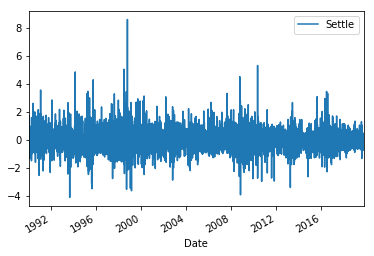

In [21]:
returns.plot()

In [44]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
adfuller(returns['Settle'])

(-87.6773623853942,
 0.0,
 0,
 7513,
 {'1%': -3.4312206955500963,
  '5%': -2.8619247816139843,
  '10%': -2.5669748148389813},
 15724.766827334091)

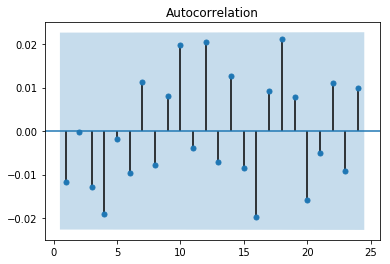

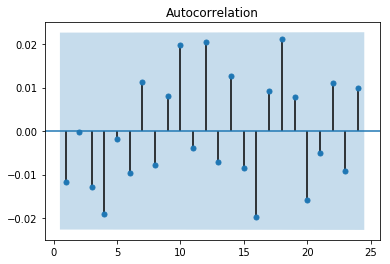

In [50]:
plot_acf(returns['Settle'], lags=24,  unbiased=True, zero=False)

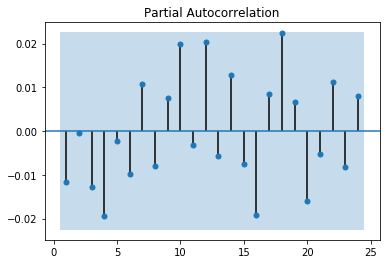

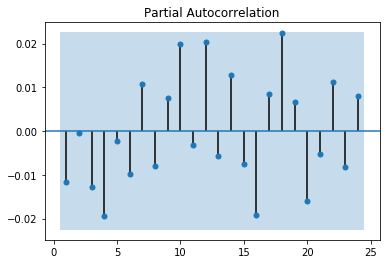

In [51]:
plot_pacf(returns['Settle'], zero=False, lags=24)

In [32]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns['Settle'], order=(2, 1))

# Fit the model and assign it to a variable called results
result = model.fit()

C:\Users\drbri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [33]:
# Output model summary results:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 26 May 2020   AIC                          15798.142
Time:                        14:02:46   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3344           +0.0000j            3.3344            0.5000
AR.2         -157.1794           +0.0000j          157.1794            0.5000
MA.1           -3.3933           +0.0000j            3.3933            0.5000
-----------------------------------------------------------------------------
"""

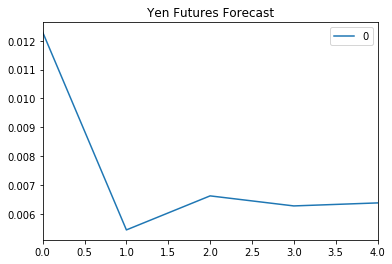

In [35]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result.forecast(steps=5)[0]).plot(title="Yen Futures Forecast")

Question: Based on the p-value, is the model a good fit?

Answer:

The first to p=2, q=1 is not good based on the large Pvalues  (p>0.8).  this is consistant with the autoregression and partial auto regression, where none of the lags are correlated.  

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [52]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(yen_futures["Settle"], order=(5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\drbri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\drbri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 26 May 2020   AIC                          83905.238
Time:                        14:18:12   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3784j            2.3409           -0.1002
AR.2            1.8920           +1.3784j            2.3409            0.1002
AR.3           -2.2711           -3.0200j            3.7787           -0.3526
AR.4           -2.2711           +3.0200j            3.7787            0.3526
AR.5          -11.1050           -0.0000j           11.1050           -0.5000
MA.1            3.3622           +0.0000j            3.3622            0.0000
-----------------------------------------------------------------------------
"""

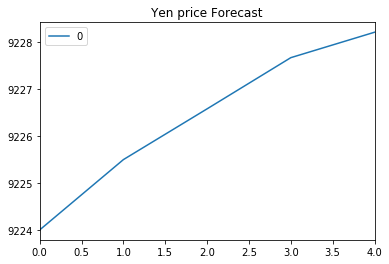

In [55]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen price Forecast")

What does the model forecast will happen to the Japanese Yen in the near term?

according to this model the yen will increase in the near term

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [56]:
import arch as arch

In [67]:
# Estimate a GARCH model:
from arch import arch_model
model = arch_model(returns['Settle'], mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit(disp="off")

In [61]:
# Summarize the model results
results.summary()

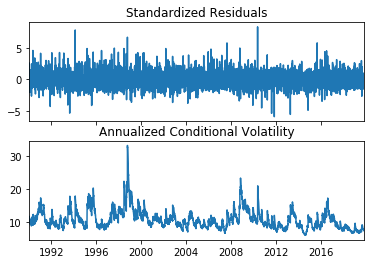

In [68]:
fig = results.plot(annualize='D')

In [62]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [63]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [64]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

h.1       h.2       h.3     h.4       h.5
Date                                                      
2019-10-15  7.434026  7.475721  7.516842  7.5574  7.597407

In [65]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date  2019-10-15
h.1     7.434026
h.2     7.475721
h.3     7.516842
h.4     7.557400
h.5     7.597407

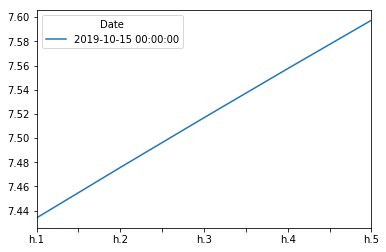

In [66]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on this analysis, it is inconclusive, the ARMA model says the yen will decrease but the ARIMA model says it will 
increase.  

Based ont he GARCH model, the volitility and thus risk for the Yen is expected to increase.  

based on the statistics surrounding these models I would not trust them.  The data set itself is not well set up for 
these models since the data has no correlation from time point to time point.  